在这一节中，我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。
我们将只使用张量和自动求导。

In [4]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

我们将根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。
线性模型参数 $w=[2,-3,4]^T$ $b=4.2$ 噪声项 $\epsilon$ 生成数据集和标签 $y=Xw+b+\epsilon$
标准差0.01
生成数据集：

In [5]:
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w))) #高斯分布的随机数（均值，标准差，形状）
    
    y=torch.matmul(X,w)+b#矩阵乘法
    #真实
    y+=torch.normal(0,0.01,y.shape)
    #扰动
    return X,y.reshape((-1,1))

In [ ]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
print(features)

tensor([ 2.0000, -3.4000])
tensor([[-1.0622, -0.7725],
        [ 1.0451,  0.1127],
        [-2.0268,  1.5929],
        ...,
        [ 0.6241,  0.5128],
        [ 2.0363,  1.3611],
        [ 0.0262, -0.2734]])


features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值
特征——输入
标签——输出或目标

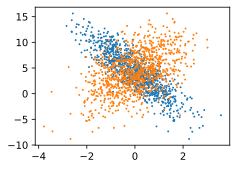

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1)
#分别固定x1和x2不变，得到的就是直线

读取数据集
训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。
定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成
大小为batch_size的小批量。每个小批量包含一组特征和标签

In [ ]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)#索引打乱顺序
    for i in range(0,num_examples,batch_size):#打乱后的按照顺序分块
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        yield features[batch_indices],labels[batch_indices]

我们利用GPU并行运算的优势，处理合理大小的“小批量”。每个样本都可以并行地进行模型计算，且
每个样本损失函数的梯度也可以被并行计算。

在 PyTorch 里，张量可以用「张量索引」来取子集
```python

features = torch.tensor([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0],
    [7.0, 8.0]
])  # (4,2)

batch_indices = torch.tensor([2, 0])  # 取第3行和第1行
```

上面实现的迭代对教学来说
很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。例如，它要求我们将所有数据加载到内存中，并
执行大量的随机内存访问。在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的
数据和数据流提供的数据。

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要**先有一些参数**。在下面的代码中，我
们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [ ]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

须定义模型，将模型的输入和参数同模型的输出关联起来.
要计算线性模型的输出，我们只需计算输入特征X和模型权重w的矩阵‐向量乘法后加上偏置b。
广播机制：当我们用一个向量加一个标量时，标量会被加到向量的每个
分量上。

In [ ]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b